In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
lwes = {
    "BN_origin": "E:\Code\wetland\data\GRAiCE\GRAiCE_BiLSTM.nc",
    "CSR": "data/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-corrections.nc",
    "interp": "data/LWE_interpolated.nc",
    "BN_us": "data/LWE_BN_upscaled.nc",
}
datasets = {
    "bno": xr.open_dataset(lwes["BN_origin"]),
    "csr": xr.open_dataset(lwes["CSR"]),
    "interp": xr.open_dataset(lwes["interp"]),
    "bnu": xr.open_dataset(lwes["BN_us"]),
}

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\FireFighter\AppData\Local\Temp\ipykernel_13636\3607357557.py:2: SyntaxWarning: invalid escape sequence '\C'
  "BN_origin": "E:\Code\wetland\data\GRAiCE\GRAiCE_BiLSTM.nc",


In [5]:
import pandas as pd

time_bno = pd.date_range("1984-01-01", periods=datasets["bno"].sizes["time"], freq="MS")
datasets["bno"] = datasets["bno"].assign_coords(time=time_bno)
datasets["bnu"] = datasets["bnu"].assign_coords(time=time_bno)
datasets["bno"]

<xarray.Dataset> Size: 473MB
Dimensions:  (time: 456, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1984-01-01 1984-02-01 ... 2021-12-01
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    TWSA     (time, lat, lon) float32 473MB ...
Attributes:
    title:     TWSA reconstruction from 1984 to 2021 - BiLSTM
    subtitle:  Monthly TWSA estimates obtained with BiLSTM model (all predict...
    anything:  Monthly predictors: precipitation, snow depth water equivalent...

In [6]:
time_csr = pd.to_datetime(datasets["csr"].time.values, origin="2002-01-01", unit="D")
datasets["csr"] = datasets["csr"].assign_coords(time=time_csr)
datasets["csr"]

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 248, timebound: 2, lat: 720, lon: 1440)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-04-18 ... 2025-08-16T12:00:00
  * lat            (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Dimensions without coordinates: timebound
Data variables:
    time_bounds    (time, timebound) float32 2kB ...
    lwe_thickness  (time, lat, lon) float32 1GB ...
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    filename:                   netcdf/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      CSR GRACE and GRACE-FO MASCON RL0603M
    subtitle:                   RL06.3 GRACE/GRACE-FO Total water storage wit...
    ...                         ...
    user_note_3:                Ellipsoidal correction has been applied. The ...
    user_note_4:                This GRACE-FO RL06.3 data is an updated versi...
    date_created:               2025-10-21T11:40:22Z
    variable:                   liquid water equivalent thickness
    label:                      RL0603rc24cE
    Mask:                       Global

In [7]:
time_interp = pd.date_range(
    start="2002-04-01", periods=datasets["interp"].sizes["time"], freq="MS"
)
datasets["interp"] = datasets["interp"].assign_coords(time=time_interp)
datasets["interp"]

<xarray.Dataset> Size: 2GB
Dimensions:        (time: 248, lat: 720, lon: 1440)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-04-01 ... 2022-11-01
  * lat            (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    lwe_thickness  (time, lat, lon) float64 2GB ...

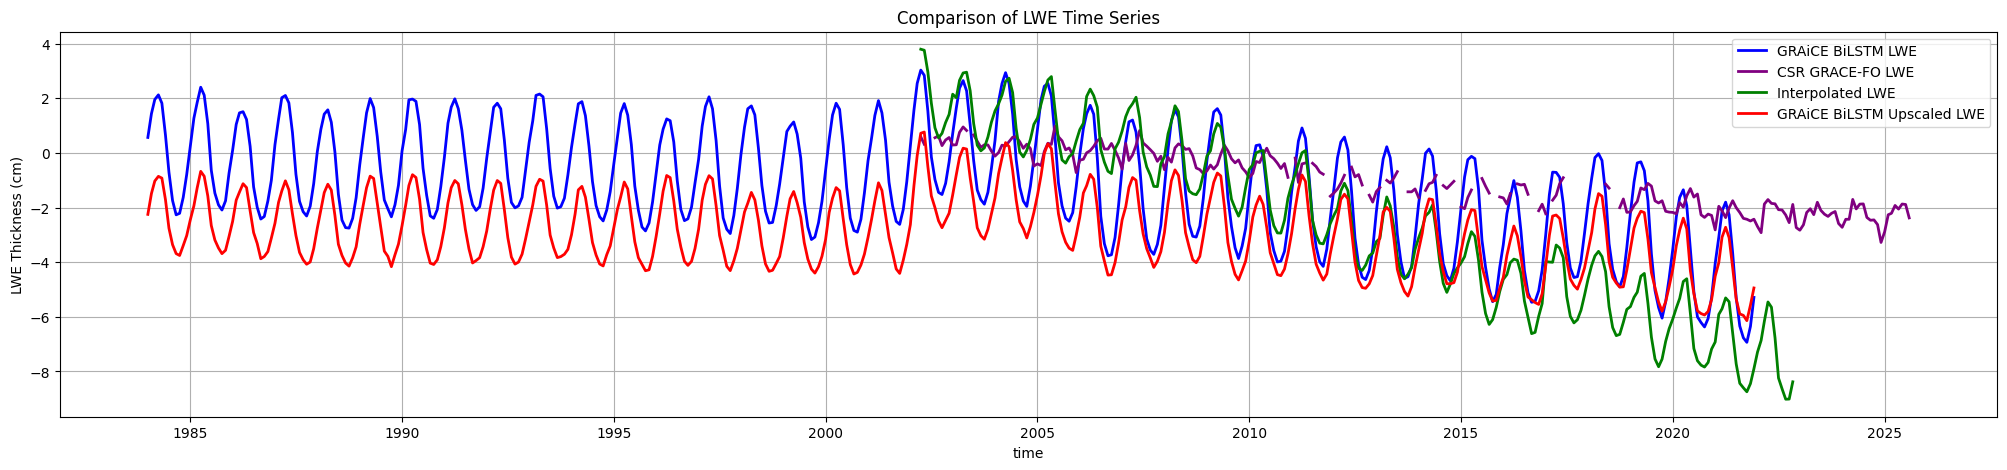

In [10]:
fig, ax = plt.subplots(figsize=(25, 5))
(
    datasets["bno"]["TWSA"]
    # .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM LWE", color="blue", linewidth=2)

(
    datasets["csr"]["lwe_thickness"]
    # .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="CSR GRACE-FO LWE", color="purple", linewidth=2)

(
    datasets["interp"]["lwe_thickness"]
    # .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"]).resample(time="MS").mean()
    * 100
).plot(ax=ax, label="Interpolated LWE", color="green", linewidth=2)

(
    datasets["bnu"]["TWSA"]
    # .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM Upscaled LWE", color="red", linewidth=2)

ax.set_title("Comparison of LWE Time Series")
ax.set_ylabel("LWE Thickness (cm)")
ax.legend()
ax.grid()

In [11]:
# apply land mask
land_mask = xr.open_dataset("data/CSR_GRACE_GRACE-FO_RL06_Mascons_v02_LandMask.nc")
land_mask

<xarray.Dataset> Size: 4MB
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    LO_val   (lat, lon) float32 4MB ...
Attributes: (12/14)
    Conventions:     CF-1.5
    data_reference:  Save, H., S. Bettadpur, B. D. Tapley (2016), High resolu...
    data_author:     Himanshu Save (save@csr.utexas.edu)
    url:             https://doi.org/10.15781/cgq9-nh24
    doi:             10.15781/cgq9-nh24
    summary:         CSR RL06 Mascon V02 Land Mask
    ...              ...
    variable:        Land=1 and Ocean=0
    Longitudes:       LON1_NLONS_DLON=0.125. 1440 0.25
    Latitudes:        LAT1_NLATS_DLAT=-89.875 720 0.25
    label:           Land_Mask_RL06M
    Mask:            Global
    DATE_CREATED:    Fri Jul 12 10:41:31 CDT 2019

In [17]:
# apply land mask to CSR dataset
mask = land_mask["LO_val"].values.astype(bool)
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(720, 1440))

In [ ]:
# this mask is not good, use bnu mask
mask = datasets["bnu"]["TWSA"].isel(time=0).notnull().values

# match dimensions
mask = np.flipud(mask)  # flip latitudes
mask = np.roll(mask, mask.shape[1] // 2, axis=1)  # roll longitudes -180-180 to 0-360

In [46]:
csr_masked = datasets["csr"]["lwe_thickness"].where(mask)
csr_masked

<xarray.DataArray 'lwe_thickness' (time: 248, lat: 720, lon: 1440)> Size: 1GB
array([[[-2.7126658, -2.7126658, -2.7126658, ..., -2.7126658,
         -2.7126658, -2.7126658],
        [-2.7126658, -2.7126658, -2.7126658, ..., -2.7126658,
         -2.7126658, -2.7126658],
        [-3.493693 , -3.493693 , -3.493693 , ..., -3.493693 ,
         -3.493693 , -3.493693 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.9613819, -1.9613819, -1.9613819, ..., -1.9613819,
         -1.9613819, -1.9613819],
        [-1.9613819, -1.9613819, -1.9613819, ..., -1.9613819,
         -1.9613819, -1.9613819],
        [-2.8264503, -2.8264503, -2.8264503, ..., -2.8264503,
         -2.8264503, -2.8264503],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[38.334103 , 38.334103 , 38.334103 , ..., 38.334103 ,
         38.334103 , 38.334103 ],
        [38.334103 , 38.334103 , 38.334103 , ..., 38.334103 ,
         38.334103 , 38.334103 ],
        [26.981081 , 26.981081 , 26.981081 , ..., 26.981081 ,
         26.981081 , 26.981081 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], shape=(248, 720, 1440), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-18 ... 2025-08-16T12:00:00
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    grid_mapping:   WGS84
    standard_name:  Liquid_Water_Equivalent_Thickness
    long_name:      Liquid_Water_Equivalent_Thickness
    Units:          cm

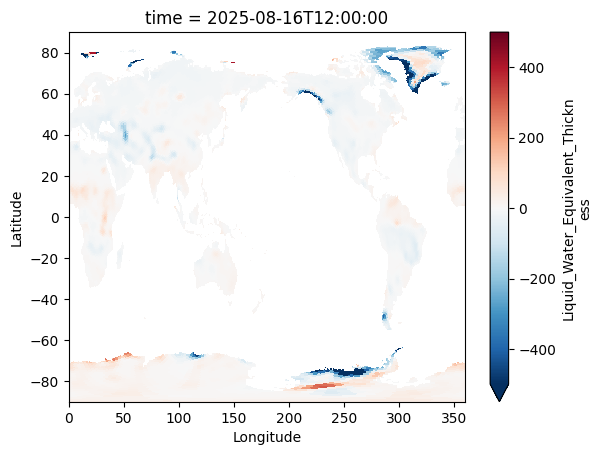

In [48]:
csr_masked.isel(time=-1).plot(vmax=500, vmin=-500, cmap="RdBu_r")

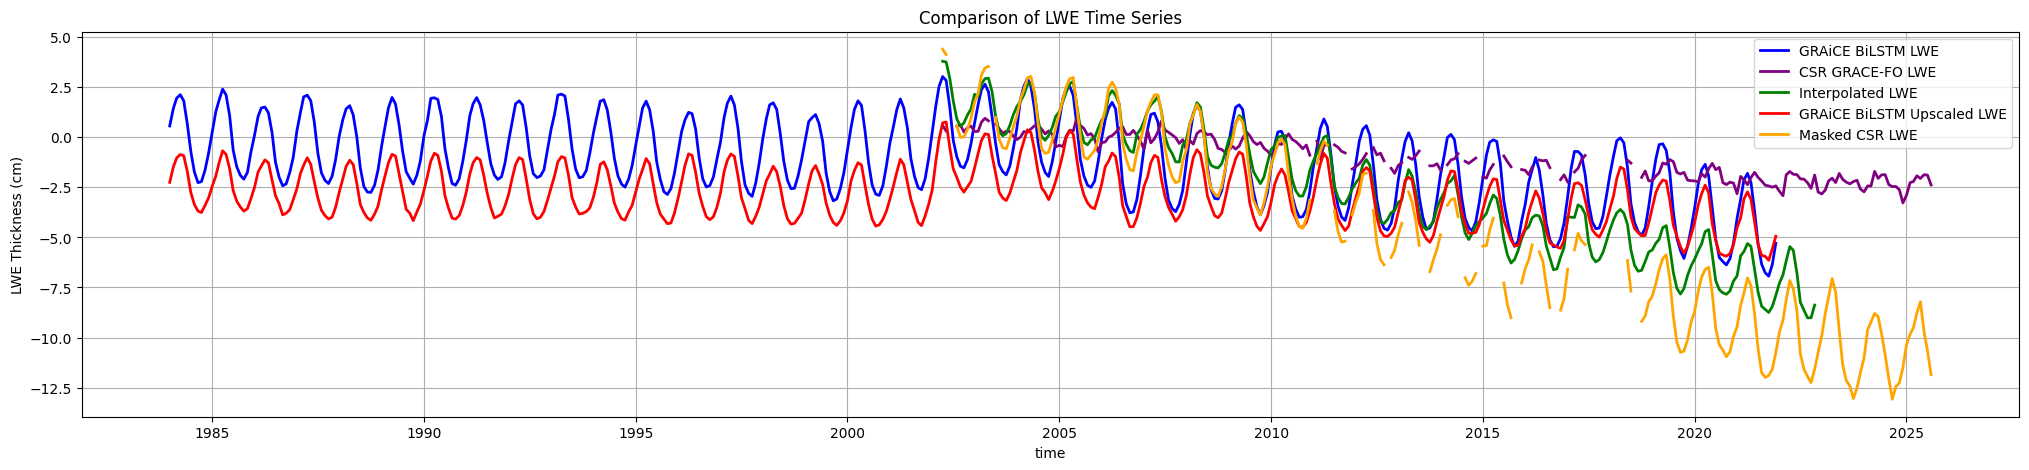

In [49]:
fig, ax = plt.subplots(figsize=(25, 5))
(
    datasets["bno"]["TWSA"]
    # .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM LWE", color="blue", linewidth=2)

(
    datasets["csr"]["lwe_thickness"]
    # .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="CSR GRACE-FO LWE", color="purple", linewidth=2)

(
    datasets["interp"]["lwe_thickness"]
    # .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"]).resample(time="MS").mean()
    * 100
).plot(ax=ax, label="Interpolated LWE", color="green", linewidth=2)

(
    datasets["bnu"]["TWSA"]
    # .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM Upscaled LWE", color="red", linewidth=2)

(
    csr_masked
    # .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="Masked CSR LWE", color="orange", linewidth=2)
ax.set_title("Comparison of LWE Time Series")
ax.set_ylabel("LWE Thickness (cm)")
ax.legend()
ax.grid()

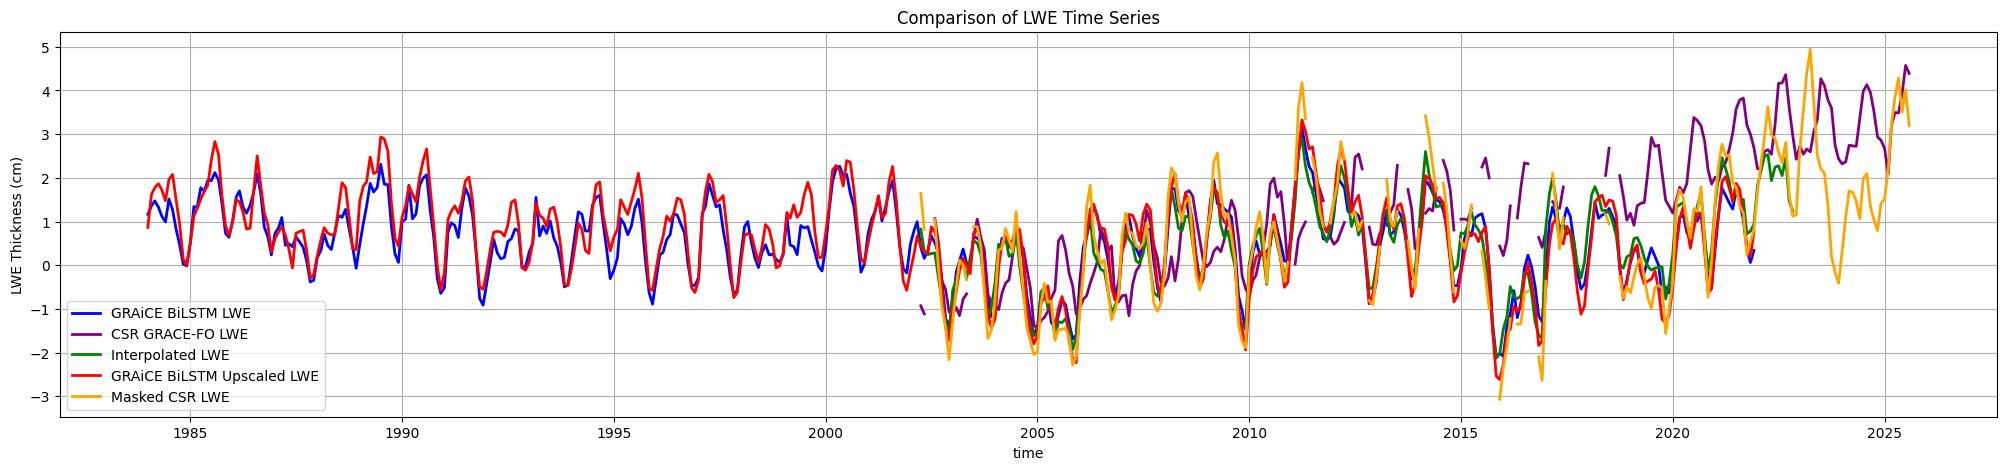

In [50]:
fig, ax = plt.subplots(figsize=(25, 5))
(
    datasets["bno"]["TWSA"]
    .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM LWE", color="blue", linewidth=2)

(
    datasets["csr"]["lwe_thickness"]
    .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="CSR GRACE-FO LWE", color="purple", linewidth=2)

(
    datasets["interp"]["lwe_thickness"]
    .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
    * 100
).plot(ax=ax, label="Interpolated LWE", color="green", linewidth=2)

(
    datasets["bnu"]["TWSA"]
    .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM Upscaled LWE", color="red", linewidth=2)

(
    csr_masked.sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="Masked CSR LWE", color="orange", linewidth=2)
ax.set_title("Comparison of LWE Time Series")
ax.set_ylabel("LWE Thickness (cm)")
ax.legend()
ax.grid()

We trust the BiLSTM in the tropical region.

In [51]:
lwe_complete = datasets["bnu"]["TWSA"].copy()
lwe_complete = lwe_complete.reindex(
    time=pd.date_range("1984-01-01", "2025-08-01", freq="MS")
)
for t in csr_masked.time.values:
    related_date = np.datetime64(
        f"{pd.to_datetime(t).year}-{pd.to_datetime(t).month:02d}-01"
    )
    if related_date in lwe_complete.time.values:
        print(related_date)
        data = csr_masked.sel(time=t).values
        data = np.flipud(data)  # flip latitude
        # change 0-360 to -180 to 180
        data = np.roll(data, data.shape[1] // 2, axis=1)
        lwe_complete.loc[dict(time=related_date)] = data

2002-04-01
2002-05-01
2002-08-01
2002-09-01
2002-10-01
2002-11-01
2002-12-01
2003-01-01
2003-02-01
2003-03-01
2003-04-01
2003-05-01
2003-07-01
2003-08-01
2003-09-01
2003-10-01
2003-11-01
2003-12-01
2004-01-01
2004-02-01
2004-03-01
2004-04-01
2004-05-01
2004-06-01
2004-07-01
2004-08-01
2004-09-01
2004-10-01
2004-11-01
2004-12-01
2005-01-01
2005-02-01
2005-03-01
2005-04-01
2005-05-01
2005-06-01
2005-07-01
2005-08-01
2005-09-01
2005-10-01
2005-11-01
2005-12-01
2006-01-01
2006-02-01
2006-03-01
2006-04-01
2006-05-01
2006-06-01
2006-07-01
2006-08-01
2006-09-01
2006-10-01
2006-11-01
2006-12-01
2007-01-01
2007-02-01
2007-03-01
2007-04-01
2007-05-01
2007-06-01
2007-07-01
2007-08-01
2007-09-01
2007-10-01
2007-11-01
2007-12-01
2008-01-01
2008-02-01
2008-03-01
2008-04-01
2008-05-01
2008-06-01
2008-07-01
2008-08-01
2008-09-01
2008-10-01
2008-11-01
2008-12-01
2009-01-01
2009-02-01
2009-03-01
2009-04-01
2009-05-01
2009-06-01
2009-07-01
2009-08-01
2009-09-01
2009-10-01
2009-11-01
2009-12-01
2010-01-01

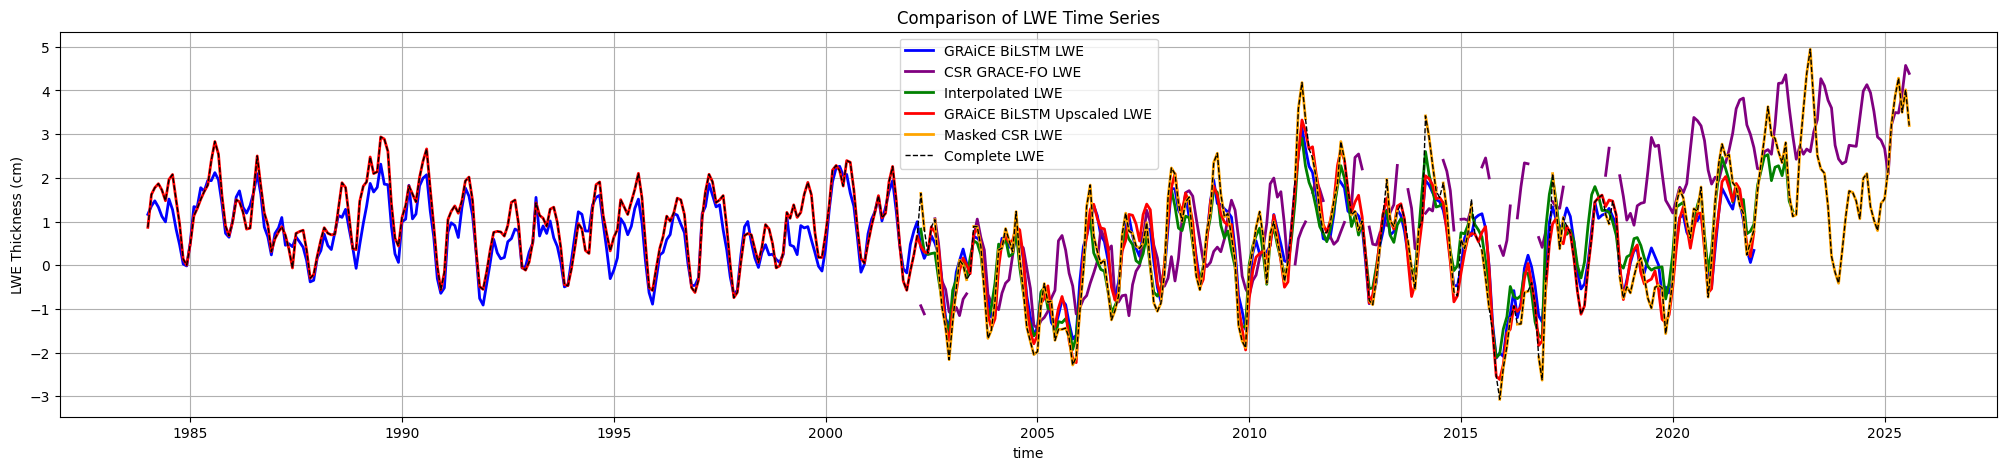

In [52]:
fig, ax = plt.subplots(figsize=(25, 5))
(
    datasets["bno"]["TWSA"]
    .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM LWE", color="blue", linewidth=2)

(
    datasets["csr"]["lwe_thickness"]
    .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="CSR GRACE-FO LWE", color="purple", linewidth=2)

(
    datasets["interp"]["lwe_thickness"]
    .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
    * 100
).plot(ax=ax, label="Interpolated LWE", color="green", linewidth=2)

(
    datasets["bnu"]["TWSA"]
    .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GRAiCE BiLSTM Upscaled LWE", color="red", linewidth=2)

(
    csr_masked.sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="Masked CSR LWE", color="orange", linewidth=2)

(
    lwe_complete.sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="Complete LWE", color="black", linewidth=1, linestyle="--")
ax.set_title("Comparison of LWE Time Series")
ax.set_ylabel("LWE Thickness (cm)")
ax.legend()
ax.grid()

In [53]:
# save complete lwe to netcdf
# append units and attributes
lwe_complete.name = "lwe_thickness"
lwe_complete.attrs["units"] = "cm"
lwe_complete.attrs["long_name"] = "Complete Land Water Equivalent Thickness"
lwe_complete.attrs["description"] = (
    """Land Water Equivalent Thickness dataset completed by GRAiCE BiLSTM Upscaled LWE 
    and CSR GRACE-FO LWE over the period from 1984-01 to 2025-08."""
)

lwe_complete.to_netcdf("data/LWE_complete_1984_2025.nc")

In [54]:
# save a land mask of complete lwe
land_mask_complete = lwe_complete.isel(time=0).notnull().astype(bool)
land_mask_complete.name = "land_mask"
land_mask_complete.to_netcdf("data/Land_mask.nc")